# Minimax Probability Machine

## Generate datasets

In [18]:
using Plots
using LinearAlgebra
using Statistics
using Distributions
using JuMP, AmplNLWriter, Gurobi

include("utils.jl")

plot_data (generic function with 1 method)

## Plot dataset

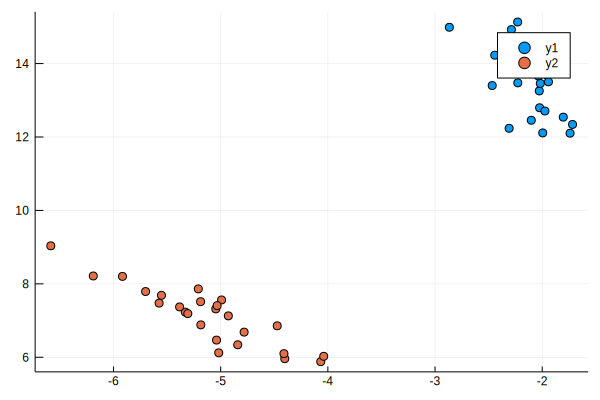

In [20]:
n_samples = 50

#X_original, Y_original = get_clouds()
#X_original, Y_original = get_multivariate_normal()
#X_original, Y_original = make_blobs(n_samples=n_samples, centers=2, random_state=422)
#X_original, Y_original = make_moons(n_samples=n_samples, noise=0.05)
# Anisotropicly distributed data
X_original, Y_original = make_blobs(n_samples=n_samples, centers=2, random_state=nothing)
transformation = [0.6 -0.6; -0.4 0.8]
X_original = X_original*transformation

theta = 2*pi*rand()
rotation = [cos(theta) -sin(theta); sin(theta) cos(theta)]
X_original[Y_original.==-1,:] = X_original[Y_original.==-1,:]*rotation
# blobs with varied variances
#X_original, Y_original = make_blobs(n_samples=n_samples, centers=2, cluster_std=[1.0, 2.5],random_state=nothing);

#noisy_circles = datasets.make_circles(n_samples=n_samples, factor=0.5, noise=0.05)
no_structure = (rand(n_samples, 2), nothing)

#plot_data((X_original, Y_original));
plot_classes(X_original, Y_original);

## Define optimization models

### Minimax Probability Machine

The optimization problem that the MPM solves is the following SOCP:

%% latex
\begin{equation*}
\begin{aligned}
\underset{\textbf{a}}{\text{min}}
&&& \sqrt{\textbf{a}^T \Sigma_x \textbf{a}} + \sqrt{\textbf{a}^T \Sigma_y \textbf{a}} \\
\text{s.t.}
&&&  \textbf{a}^T (\overline{\textbf{x}} - \overline{\textbf{y}}) = 1 \\
\end{aligned}
\end{equation*}

Once the optimal value for $\textbf{a}$ has been found, $b$ (the separating line intercept) can computed as follows:

\begin{equation}
b = \textbf{a}^T \overline{\textbf{x}} - \dfrac{ \sqrt{\textbf{a}^T \Sigma_x \textbf{a}} }{ \sqrt{\textbf{a}^T \Sigma_x \textbf{a}} + \sqrt{\textbf{a}^T \Sigma_y \textbf{a}} }
\end{equation}

In [21]:
# Minimax Probability Machine
function solve_mpm(X,Y)
    # Minimax Probability Machine
    println(size(X))

    # calculate mean of data
    mean_x = dropdims(mean(X, dims=1), dims=1)
    mean_y = dropdims(mean(Y, dims=1), dims=1)

    # calculate covariance matrix of data
    sigmaX = cov(X, dims=1)
    sigmaY = cov(Y, dims=1)

    # number of classes
    n = 2

    # Optimization model
    model = Model(solver=AmplNLSolver("couenne", [""]))
    #model = Model(solver=GurobiSolver(TimeLimit=400))

    # Variables
    @variable(model, a[1:n])
    #@variable(model, ξ >= 1e-7)

    # Objective
    @NLobjective(model, Min, sqrt( sum(a[i]*sigmaX[i,j]*a[j] for i=1:n, j=1:n)) +
                           sqrt( sum(a[i]*sigmaY[i,j]*a[j] for i=1:n, j=1:n)));

    # Constraints
    @constraint(model, con, sum(a[i] * (mean_x[i] - mean_y[i]) for i=1:n) == 1);
    #@constraint(model, con, sum(a[i] * (mean_y[i] - mean_x[i]) for i=1:n) == 1);

    # Set initial value to 1 to prevent the solver from trying to calculate the derivative at sqrt(0)
    setvalue(a, [1;1])

    println()
    status = solve(model)
    solvetime = getsolvetime(model)
    obj_value = getobjectivevalue(model);
    println("Solve time: ", solvetime)
    println("Objective=", obj_value);


    a = getvalue(a)
    println("a=$a")

    # calculate b
    b = a'*mean_x - sqrt(a'*sigmaX*a) / (sqrt(a'*sigmaX*a) + sqrt(a'*sigmaY*a))
    return a, b
end


solve_mpm (generic function with 1 method)

### Linear SVM

The optimization problem that the Linear SVM solves is the following QP:

%% latex
\begin{equation*}
\begin{aligned}
\underset{\textbf{w},b,\xi}{\text{min}}
&&& \dfrac{1}{2} \| \textbf{w}\|^2 + C \sum_{i=1}^{N} \xi^{(i)}  \\
\text{s.t.}
&&&  y^{(i)} (\textbf{w}^T \textbf{x}^{(i)} + b ) \geq 1 - \xi^{(i)} \\
\end{aligned}
\end{equation*}

In [22]:
# Linear SVM
function solve_svm(x,y,C)
    num_samples, N_dims = size(x)

    # Optimization model
    #model = Model(solver=AmplNLSolver("couenne", [""]));
    model = Model(solver=GurobiSolver(TimeLimit=400))

    # Variables
    @variable(model, w[1:N_dims])
    @variable(model, b)
    @variable(model, ξ[1:num_samples] >= 0.0)

    # Objective
    # ξ
    @objective(model, Min, 0.5*sum(w[k]^2 for k=1:N_dims) + C*sum(ξ[i] for i=1:num_samples))

    # Constraints
    @constraint(model, con[i=1:num_samples], y[i]*(sum(w[j]*x[i,j] for j=1:N_dims) + b) >= 1.0 - ξ[i])
    
    # Solve
    println()
    status = solve(model)
    solvetime = getsolvetime(model)
    obj_value = getobjectivevalue(model);
    println("Solve time: ", solvetime)
    println("Objective=", obj_value);

    # Recover variable values
    w_opt = getvalue(w)
    b_opt = getvalue(b)

    return w_opt, b_opt
end

solve_svm (generic function with 1 method)

## Solve optimization problem

In [23]:
X = X_original[Y_original.==-1,:]
Y = X_original[Y_original.==1,:]

a,b = solve_mpm(X,Y)

(25, 2)

Couenne 0.5.6 -- an Open-Source solver for Mixed Integer Nonlinear Optimization
Mailing list: couenne@list.coin-or.org
Instructions: http://www.coin-or.org/Couenne
couenne: 
ANALYSIS TEST: Couenne: new cutoff value 1.3237562525e+000 (0 seconds)
NLP0012I 
              Num      Status      Obj             It       time                 Location
NLP0014I             1         OPT 0.10482247        7 0
Couenne: new cutoff value 1.0482246567e-001 (0 seconds)
Loaded instance "C:\Users\Breno\.julia\packages\AmplNLWriter\V1gW5\.solverdata\jl_89C9.tmp.nl"
Constraints:            1
Variables:              2 (0 integer)
Auxiliaries:            8 (0 integer)

Coin0506I Presolve 20 (-2) rows, 8 (-2) columns and 43 (-6) elements
Clp0000I Optimal - objective value 0
Clp0032I Optimal objective 0 - 0 iterations time 0.012, Presolve 0.01
Clp0000I Optimal - objective value 0
Cbc0012I Integer solution of 0.10482247 found by Couenne Rounding NLP after 0 iterations and 0 nodes (0.00 seconds)
NLP He

([0.146194, 0.0885455], 0.26803921098783645)

In [24]:
C = 1.0
w_svm, b_svm = solve_svm(X_original, Y_original, C)


Academic license - for non-commercial use only
Optimize a model with 50 rows, 53 columns and 200 nonzeros
Model has 2 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [1e+00, 1e+00]
  QObjective range [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 50 rows, 53 columns, 200 nonzeros
Presolved model has 2 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 Free vars  : 3
 AA' NZ     : 1.500e+02
 Factor NZ  : 2.060e+02
 Factor Ops : 8.140e+02 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   6.24025000e+05 -4.80851219e-13  0.00e+00 7.87e-07  1.00e+06     0s
   1   6.12452410e+05 -1.15874272e+03  0.00e+00 8.06e-13  6.14e+03     0s
   2   2.12273537e+03 -1.10594178e+03  0.00e+00 3.55e-15  3.23e+01     0s
 

([-0.249051, -0.292104], 1.9992487611227594)

## Plot results

### Obtain separating lines

In [25]:
# Retrieve equation for the optimal separation line
min_x = minimum(X_original[:,1])
max_x = maximum(X_original[:,1])
min_y = minimum(X_original[:,2])
max_y = maximum(X_original[:,2])
xx = range(min_x-abs(min_x)*0.1,stop=max_x+abs(max_x)*0.1,length=1000)

if abs(a[2]) > 1e-5
    y_line = - (a[1]/a[2]).*xx .+ (b/a[2])
end

a_svm = - w_svm[1] / w_svm[2]
y_line_svm = a_svm.*xx .+ (-b_svm / w_svm[2])

13.020444483227688:-0.004863541187945443:8.161766836470191

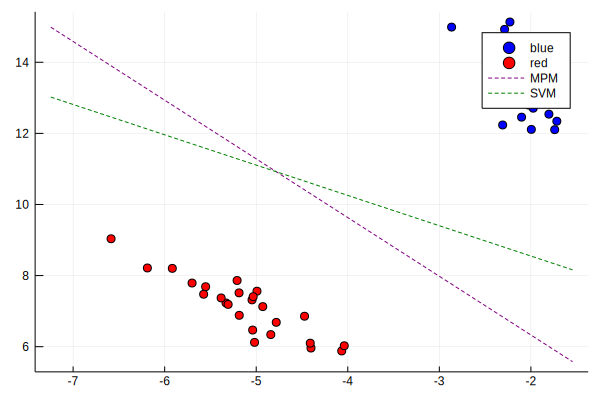

In [26]:
plt = scatter(X[:,1], X[:,2], color=:blue, leg=false, label="blue")
plt = scatter!(Y[:,1], Y[:,2], color=:red, leg=false, label="red")
if abs(a[2]) > 1e-5
    plot!(xx, y_line, linestyle=:dash, color=:purple, leg=true, label="MPM")#, ylim=(-10,10))
else
    println("vertical line")
    vline!([a[1]], linestyle=:dash, color=:gray)
end

plot!(xx, y_line_svm, linestyle=:dash, color=:green, leg=true,label="SVM")

display(plt)

In [27]:
#savefig(plt, "mpm_vs_svm.pdf");

# Kernelization

## Load Dataset

In [38]:
n_samples = 40
X_original, Y_original = get_donut(n_samples=n_samples , R_inner=5, R_outer=20)

X = X_original[Y_original.==-1,:]
Y = X_original[Y_original.==1,:];

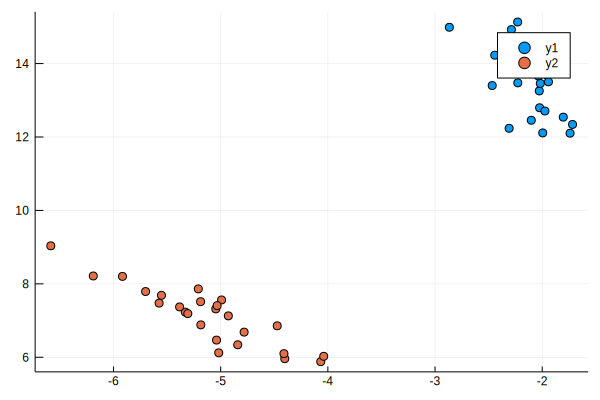

In [29]:
plot_data((X_original, Y_original))

## Kernel MPM

The optimization problem that the Kernel MPM solves is the following SOCP:

%% latex
\begin{equation*}
\begin{aligned}
\underset{\gamma}{\text{min}}
&&& \sqrt{\dfrac{1}{N_x}\gamma^T \tilde{\textbf{K}}_x^T \tilde{\textbf{K}}_x \gamma} + \sqrt{\dfrac{1}{N_y}\gamma^T \tilde{\textbf{K}}_y^T \tilde{\textbf{K}}_y \gamma} \\
\text{s.t.}
&&&  \gamma^T (\tilde{\textbf{k}}_x - \tilde{\textbf{k}}_y) = 1 \\
\end{aligned}
\end{equation*}

Once the optimal value for $\gamma$ has been found, $b$ can computed as follows:

\begin{equation}
\kappa_* = \dfrac{1}{\Big( \sqrt{\dfrac{1}{N_x}\gamma_*^T \tilde{\textbf{K}}_x^T \tilde{\textbf{K}}_x \gamma_*} + \sqrt{\dfrac{1}{N_y}\gamma_*^T \tilde{\textbf{K}}_y^T \tilde{\textbf{K}}_y \gamma_*} \Big) }
\end{equation}

\begin{equation}
b_* = \gamma_*^T \tilde{\textbf{k}}_x  - \kappa_* \sqrt{\dfrac{1}{N_x}\gamma_*^T \tilde{\textbf{K}}_x^T \tilde{\textbf{K}}_x \gamma_*}
\end{equation}

In [30]:
# Gaussian Kernel
function rbf(x1, x2; gamma=nothing)
    if gamma == nothing
        gamma = 1.0 / size(x1)[end]
        #println("gamma=$gamma")
    end
    if ndims(x1) == 1 && ndims(x2) == 1
        result = exp(-gamma * norm(x1 - x2).^2)
    elseif ndims(x1) > 1 && ndims(x2) == 1
        result = exp.(-gamma * mapslices(norm, x1 - repeat(x2',size(x1,1)), dims=2).^2)
    elseif ndims(x1) == 1 && ndims(x2) > 1
        result = exp.(-gamma * mapslices(norm, repeat(x1',size(x2,1)) - x2, dims=2).^2)
#     elseif ndims(x1) > 1 && ndims(x2) > 1 && size(x1) == size(x2)
#         result = exp.(-gamma .* mapslices(norm, x1 .- x2, dims=2).^2)
    else
        throw("unimplemented")
    end
    return result
end

rbf (generic function with 1 method)

In [31]:
function solve_kernel_mpm(X,Y)
    N_x = size(X,1)
    N_y = size(Y,1)
    Z = vcat(X,Y);
    N, n_dims = size(Z)
    K = zeros(N, N)
    for i=1:N
        for j=1:N
            K[i,j] = rbf(Z[i,:], Z[j,:])
        end
    end

    # \tilde{k}_x
    k_tilde_x = zeros(N)
    for i=1:N
        k_tilde_x[i] = (1/N_x) * sum(rbf(X[j,:], Z[i,:]) for j=1:N_x)
    end

    # \tilde{k}_y
    k_tilde_y = zeros(N)
    for i=1:N
        k_tilde_y[i] = (1/N_y) * sum(rbf(Y[j,:], Z[i,:]) for j=1:N_y)
    end
    
    K_x = K[1:N_x,:]
    K_y = K[(N_x+1):end,:]
    @assert size(K_y,1) == N_y

    K_tilde_x = K_x - ones(N_x)*k_tilde_x'
    K_tilde_y = K_y - ones(N_y)*k_tilde_y'
    K_tilde = vcat(K_tilde_x, K_tilde_y);
    
    K_tilde_xx = K_tilde_x'*K_tilde_x
    K_tilde_yy = K_tilde_y'*K_tilde_y
        
    # Optimization model
    @assert N == N_x + N_y

    model = Model(solver=AmplNLSolver("couenne", [""]));

    @variable(model, gamma[1:N]);

    # Objective
    @NLobjective(model, Min, sqrt( (1/N_x) * sum(gamma[i]*K_tilde_xx[i,j]*gamma[j] for i=1:N, j=1:N)) +
                             sqrt( (1/N_y) * sum(gamma[i]*K_tilde_yy[i,j]*gamma[j] for i=1:N, j=1:N)));

    # Constraints
    @constraint(model, con, sum(gamma[i] * (k_tilde_x[i] - k_tilde_y[i]) for i=1:N) == 1);

    setvalue(gamma, ones(N))
    
    println()
    status = solve(model)
    solvetime = getsolvetime(model)
    obj_value = getobjectivevalue(model);
    println("Status = $status")
    println("Solve time: ", solvetime)
    println("Objective=", obj_value);


    gamma = getvalue(gamma)
    println("gamma=$gamma")

    # calculate b
    Kappa = 1 / ( sqrt((1/N_x) * gamma'*K_tilde_x'*K_tilde_x*gamma) + sqrt((1/N_y) * gamma'*K_tilde_y'*K_tilde_y*gamma) )

    b = gamma'*k_tilde_x - Kappa*sqrt((1/N_x) * gamma'*K_tilde_x'*K_tilde_x*gamma)
    
    return gamma, b
end

solve_kernel_mpm (generic function with 1 method)

## Solve optimization problem

In [32]:
gamma_opt, b_opt = solve_kernel_mpm(X,Y)


Couenne 0.5.6 -- an Open-Source solver for Mixed Integer Nonlinear Optimization
Mailing list: couenne@list.coin-or.org
Instructions: http://www.coin-or.org/Couenne
couenne: 
ANALYSIS TEST: Couenne: new cutoff value 6.2962411086e+000 (0.078 seconds)
NLP0012I 
              Num      Status      Obj             It       time                 Location
NLP0014I             1      FAILED 0.36661789       14 0.154
NLP0014I             1      FAILED 0.36661789       14 0.145   resolve robustness
NLP3006W Warning : continuing branching, while there are unrecovered failures at nodes
Loaded instance "C:\Users\Breno\.julia\packages\AmplNLWriter\V1gW5\.solverdata\jl_DDE.tmp.nl"
Constraints:            1
Variables:             50 (0 integer)
Auxiliaries:         1013 (0 integer)

Clp0024I Matrix will be packed to eliminate 1 small elements
Coin0506I Presolve 11 (-205) rows, 5 (-1058) columns and 23 (-1563) elements
Clp0000I Optimal - objective value 0
Clp0032I Optimal objective 0 - 0 iterations time

┌ Warning: Not solved to optimality, status: UserLimit
└ @ JuMP C:\Users\Breno\.julia\packages\JuMP\I7whV\src\nlp.jl:1283


([-33.4647, -7.63842, 16.5932, 3.90916, -114.753, 15.4861, -11.2415, 198.225, 68.5309, 73.4271  …  -0.0940928, 2.23472, -0.754576, -19.2676, -7.56664, -0.635897, 47.8899, -2.29706, 7.39989, -1.96223], -0.04479072825869812)

## Plot results

In [39]:
N_x = size(X,1)
N_y = size(Y,1)
Z = vcat(X,Y);
N, n_dims = size(Z)

z_pred = zeros(N)

for i=1:N
    z_new = Z[i,:]
    z_pred[i] = sum(gamma_opt[i]*rbf(Z[i,:], z_new) for i=1:N) - b_opt
end
z_pred[z_pred .>= 0] = ones(sum(z_pred .>= 0))
z_pred[z_pred .< 0] = -1.0 .* ones(sum(z_pred .< 0));

In [40]:
resolution = 100

x_range = range(minimum(Z[:,1]), stop=maximum(Z[:,1]), length=resolution)
y_range = range(minimum(Z[:,2]), stop=maximum(Z[:,2]), length=resolution)

grid = zeros(resolution, resolution)
for (i,xr) in enumerate(x_range)
    # Print value of i for the user to see the progress
    if i % 10 == 0
        println("i=$i")
    end
    for (j,yr) in enumerate(y_range)
        x_new = [xr; yr]
        grid[i,j] = sum(gamma_opt[i]*rbf(Z[i,:], x_new) for i=1:N) - b_opt
    end
end
grid = grid';

i=10
i=20
i=30
i=40
i=50
i=60
i=70
i=80
i=90
i=100


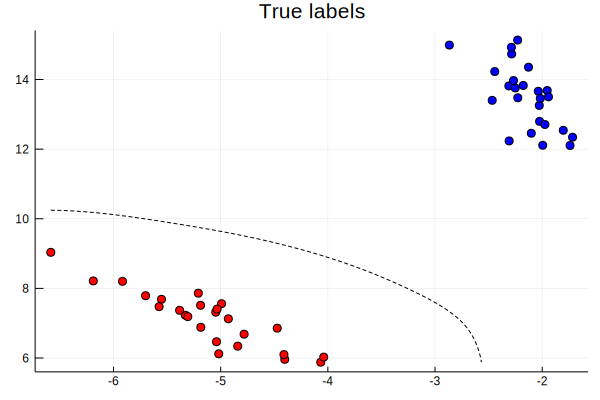

In [41]:
# Plot decision contours using grid and
# make a scatter plot of training data
#plt = contour(x_range, y_range, grid, levels=[-1,0,1], linestyles=[:dash,:dash,:dash], color=:gray)
plt = scatter(X[:,1], X[:,2], color=:blue, leg=false, title="True labels")
plt = scatter!(Y[:,1], Y[:,2], color=:red, leg=false)
plt = contour!(x_range, y_range, grid, levels=[-1,1], linestyles=[:dash,:dash], color=:gray)
plt = contour!(x_range, y_range, grid, levels=[0], linestyles=[:dash], color=:black)

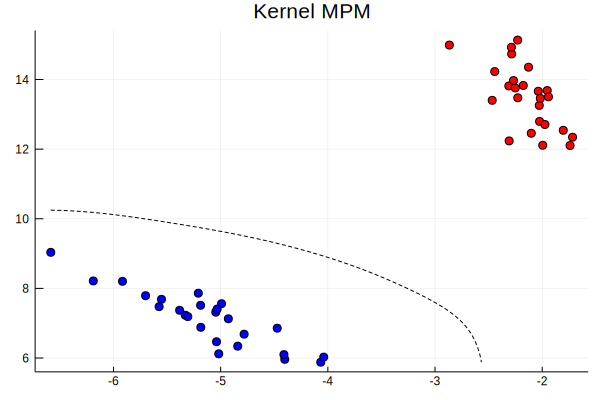

In [44]:
# Plot decision contours using grid and
# make a scatter plot of training data
plt = scatter(Z[z_pred .== -1,1], Z[z_pred .== -1,2], color=:blue, leg=false, title="Kernel MPM")
plt = scatter!(Z[z_pred .== 1,1], Z[z_pred .== 1,2], color=:red, leg=false)
plt = contour!(x_range, y_range, grid, levels=[-1,1], linestyles=[:dash,:dash], color=:gray)
plt = contour!(x_range, y_range, grid, levels=[0], linestyles=[:dash], color=:black)